## Long note - group 159
In this notebook you fan find all the methods we used. We tried few using a sklearn and then AutoML H2O. The ones using sklearn are trained on dataset X_train_observed and then crossvalidated on X_train_estimated. H2O is using sklearn function for splitting the dataset to training and testing part.

This crossvalidation is tried just on dataset A. Then the solution with the lowest mean absolute error (MAE) is chosen and used for the other datasets.


In [4]:
%load_ext autoreload

In [5]:
%autoreload

# load libraries
import pandas as pd
import numpy as np
import h2o
import sklearn
import matplotlib 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from h2o.automl import H2OAutoML

# load of our custom functions
from solutions.few_regression_types import data_preprocess


In [68]:
# read dataset A
# for simplicity, We use X_train_estimated as test data for cross validation
y = pd.read_parquet("../../dataset/A/train_targets.parquet")
X_train = pd.read_parquet("../../dataset/A/X_train_observed.parquet")
X_test = pd.read_parquet("../../dataset/A/X_train_estimated.parquet")

In [4]:
# edit data
X_train, y_train = data_preprocess.preprocess_train_data(X_train, y, "everything")
X_test, y_test = data_preprocess.preprocess_train_data(X_test, y, "everything")

## Machine learning methods

In [6]:
# Decision tree
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)

mae_tree = np.mean(np.abs(np.array(y_test) - y_pred_tree))
mae_tree  # = 616.575890061115

624.4372789807927

In [7]:
# Random forest
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, y_train.values.ravel()) # ravel part is because of scikit's data conversion warning, it does not have to be there
y_pred_forest = random_forest.predict(X_test)

mae_forest = np.mean(np.abs(np.array(y_test) - y_pred_forest))
mae_forest  # = 599.9553060312836

600.5727608942257

In [8]:
# Gradient boosting
gradient_boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1) 
gradient_boosting.fit(X_train, y_train.values.ravel())
y_pred_grad = gradient_boosting.predict(X_test)

mae_grad = np.mean(np.abs(np.array(y_test) - y_pred_grad))
mae_grad    # = 592.2928322998536

592.2928322998534

In [9]:
# Elastic net
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train.values.ravel())
y_pred_elast_net = elastic_net.predict(X_test)

mae_elast_net = np.mean(np.abs(np.array(y_test) - y_pred_elast_net))
mae_elast_net   # = 599.946498024572

C:\Users\simon\OneDrive\Dokumenty\VUT\NTNU\Machine Learning\Projekt\Projektt\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.684e+09, tolerance: 4.240e+06
  model = cd_fast.enet_coordinate_descent(


599.9464980245721

In [10]:
# Support vector regression
svr_model = SVR(kernel='rbf', C=1.)
svr_model.fit(X_train, y_train.values.ravel())
y_pred_svr = svr_model.predict(X_test)

mae_svr = np.mean(np.abs(np.array(y_test) - y_pred_svr))
mae_svr # = 473.76274242555763

473.76274242555763

In [11]:
# Hyperparameter tuning of SVR
# no need to run this section, it takes too long; the results are approx.: 
# [345, 362, 397, 437, 473, 497, 513] 
# lower C gives us better results
for C in [0.001, 0.03, 0.1, 0.3, 1, 3, 10]:
    svr_model = SVR(kernel='rbf', C=C)
    svr_model.fit(X_train, y_train.values.ravel())
    y_pred_svr = svr_model.predict(X_test)

    print(np.mean(np.abs(np.array(y_test) - y_pred_svr)), end=", ")

345.1870758178765, 362.3174570223702, 397.974746466719, 437.0422504854231, 473.76274242555763, 497.00397971674676, 513.0037055004162, 

In [90]:
#H2O AutoML

X = pd.concat([
    pd.read_parquet("../../dataset/A/X_train_observed.parquet"),
    pd.read_parquet("../../dataset/A//X_train_estimated.parquet")
], ignore_index=True)
y = pd.read_parquet("../../dataset/A//train_targets.parquet")

X_y_bacon = X.merge(y, left_on = "date_forecast", right_on = "time")
X_y_bacon = X_y_bacon.dropna(subset = "pv_measurement")

columns_to_drop = ["snow_drift:idx", "elevation:m", 'snow_melt_10min:mm', 'fresh_snow_12h:cm',
                   'fresh_snow_3h:cm',  'fresh_snow_6h:cm', 'wind_speed_w_1000hPa:ms', 
                   'snow_water:kgm2', 'snow_density:kgm3', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 
                   'wind_speed_v_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_10m:ms',
                   'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'dew_or_rime:idx', 
                   'date_forecast', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J', 
                   'dew_point_2m:K','super_cooled_liquid_water:kgm2', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'prob_rime:p','date_forecast']   

X_y_bacon.drop(columns=columns_to_drop+['time'], inplace=True)

train,test = sklearn.model_selection.train_test_split(X_y_bacon, test_size = 0.20)

h2o.init(max_mem_size = "16G") # If u have more RAM change the parameter

train_frame = h2o.H2OFrame(train)
test_frame = h2o.H2OFrame(test)

x = train_frame.columns[:-1] 
y = train_frame.columns[-1] 

aml = H2OAutoML(max_runtime_secs = 60,
                sort_metric = "MAE",
                stopping_metric = "MAE",
                seed = 7213712285)
aml.train(x = x, 
          y = y,
          training_frame = train_frame,
          validation_frame = test_frame)

print(aml.leaderboard)
best_model = aml.get_best_model(criterion='MAE')

h2o.shutdown()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 27 mins
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,"21 days, 8 hours and 54 minutes"
H2O_cluster_name:,H2O_from_python_simon_oebwgv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.00 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
X_train_frame: (25545, 21)
X_test_frame: (8516, 21)
AutoML progress: |█
19:21:29.704: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
19:21:29.704: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse     mse      mae    rmsle    mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_7_20231106_192129     434.657  188926  196.063      nan                    188926
StackedEnsemble_AllModels_1_AutoML_7_20231106_192129     435.113  189324  194.854      nan    

C:\Users\simon\AppData\Local\Temp\ipykernel_10008\2148366426.py:46: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


H2O session _sid_ba80 closed.


# Prediction on real test data


Usage of Support Vector Regression on data sets A,B,C.

In [ ]:
# Support Vector Regression
prediction = []

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    # preprocess the data
    X_train, y_train = data_preprocess.preprocess_train_data(X_train, y_train, "everything")
    X_test = data_preprocess.preprocess_test_data(X_test, "everything")
    # learn 
    model = SVR(kernel='rbf', C=.001)
    model.fit(X_train, y_train.values.ravel())
    prediction = np.concatenate((prediction, model.predict(X_test)))
prediction[prediction < 0.] = 0. # energy production can't be negative
df = pd.DataFrame({'prediction': prediction})
df.to_csv('svr.csv', index_label='id')
print("done")

Usage of H2O AutoML on data sets A,B,C. There are few versions. We figured out some work better than the others.

# H2O with data preprocess - remove NaNs, columns (V1)


In [ ]:
# H2O with data preprocess - remove NaNs, columns (V1)

all_predictions = pd.DataFrame()
# Init of H2O
h2o.init(max_mem_size = "16G") # If u have more RAM change the parameter

for letter in ['A', 'B', 'C']:
    # Load data
    print(f"dataset {letter}")
    # Load data from Parquet files and concatenate them into a single DataFrame 'X'
    X = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    
    # Preprocess the data
    
    # Merge DataFrame 'X' and 'y' based on the common column "date_forecast"
    X_y_bacon = X.merge(y, left_on = "date_forecast", right_on = "time")
    
    # Remove rows with missing values in the "pv_measurement" variable
    X_y_bacon = X_y_bacon.dropna(subset = "pv_measurement")
    X_y_bacon.drop(columns=['time'], inplace=True)
    
    # List of columns to be dropped
   
    columns_to_drop = ["snow_drift:idx", "elevation:m", 'snow_melt_10min:mm','fresh_snow_12h:cm',
                       'fresh_snow_3h:cm',  'fresh_snow_6h:cm', 'wind_speed_w_1000hPa:ms', 
                       'snow_water:kgm2', 'snow_density:kgm3', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 
                       'wind_speed_v_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_10m:ms',
                       'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'dew_or_rime:idx', 
                       'date_forecast', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J', 
                       'dew_point_2m:K','super_cooled_liquid_water:kgm2', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'prob_rime:p','date_forecast']   
    
    
    # Remove specified columns from training data
    X_y_bacon.drop(columns=columns_to_drop+['time'], inplace=True)
    
    # Load test data and remove specified columns
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    X_test = X_test.iloc[::4]
    X_test.drop(columns=columns_to_drop, inplace=True)
    x_test = h2o.H2OFrame(X_test)

    
    # Split data into training and validation frames (80:20)
    train,test = sklearn.model_selection.train_test_split(X_y_bacon, test_size = 0.20)

    train_frame = h2o.H2OFrame(train)
    test_frame = h2o.H2OFrame(test)
    
    x = train_frame.columns[:-1] 
    y = train_frame.columns[-1] 
    
    # Create an AutoML model
    aml = H2OAutoML(max_runtime_secs = 60,
                    sort_metric = "MAE",
                    stopping_metric = "MAE",
                    seed = 7213712285) #7213712285 
    aml.train(x = x, 
              y = y,
              training_frame = train_frame,
              validation_frame = test_frame)
    
    print(aml.leaderboard)
    best_model = aml.get_best_model(criterion='MAE')
    second_best_model = h2o.get_model(h2o.as_list(aml.leaderboard)["model_id"].iloc[1])
    
    # Make predictions on test data and make CSV file
    prediction1 = best_model.predict(x_test)
    predictions1_df = h2o.as_list(prediction1)
    predictions1_df[predictions1_df < 0.] = 0.
        
    all_predictions = pd.concat([all_predictions, predictions1_df], ignore_index=True)
    all_predictions.to_csv('AutoML_H2O-V1.csv', index_label='id')
    print("CSV file updated")

# Explain the best model on the validation frame for model interpretation
best_model.explain(test_frame)

# Shut down H2O
h2o.shutdown()
print("Done")

# H2O with data preprocess and two predictors (V2)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,10 hours 36 mins
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_simon_nx9sqt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.17 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


dataset A
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
23:45:02.930: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
23:45:02.931: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                      mae     rmse     mse    rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_29_20231109_234502     183.109  407.18   165796      nan                    165796
StackedEnsemble_AllModels_3_AutoML_29_2

C:\Users\simon\OneDrive\Dokumenty\Solar-Energy-Production-Forecasting\venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'time': substituting in a column of NaN
  warnings.warn(w)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\simon\OneDrive\Dokumenty\Solar-Energy-Production-Forecasting\venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'time': substituting in a column of NaN
  warnings.warn(w)


CSV file updated
dataset B
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
23:49:50.743: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
23:49:50.744: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                      mae     rmse      mse    rmsle    mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_30_20231109_234950     28.7513  63.921   4085.9       nan                   4085.9
StackedEnsemble_AllMo

C:\Users\simon\OneDrive\Dokumenty\Solar-Energy-Production-Forecasting\venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'time': substituting in a column of NaN
  warnings.warn(w)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\simon\OneDrive\Dokumenty\Solar-Energy-Production-Forecasting\venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'time': substituting in a column of NaN
  warnings.warn(w)


CSV file updated
dataset C
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
23:54:41.743: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
23:54:41.744: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                      mae     rmse      mse    rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_31_20231109_235441     20.4537  50.6886  2569.33      nan                   2569.33
StackedEnsemble_AllM

C:\Users\simon\OneDrive\Dokumenty\Solar-Energy-Production-Forecasting\venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'time': substituting in a column of NaN
  warnings.warn(w)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\simon\OneDrive\Dokumenty\Solar-Energy-Production-Forecasting\venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset is missing column 'time': substituting in a column of NaN
  warnings.warn(w)


CSV file updated


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

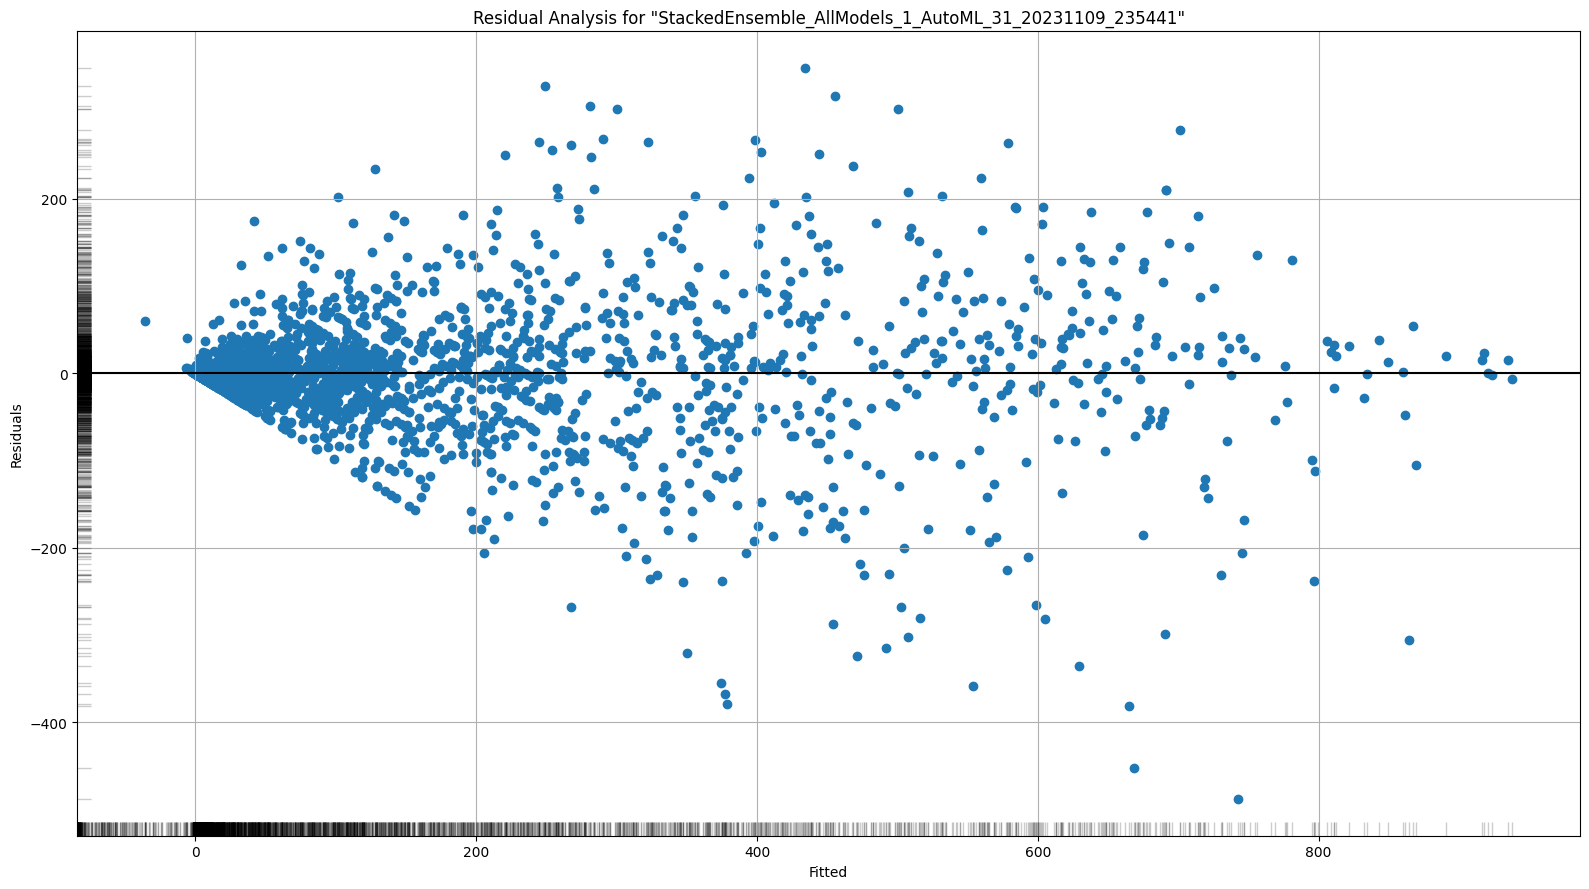

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

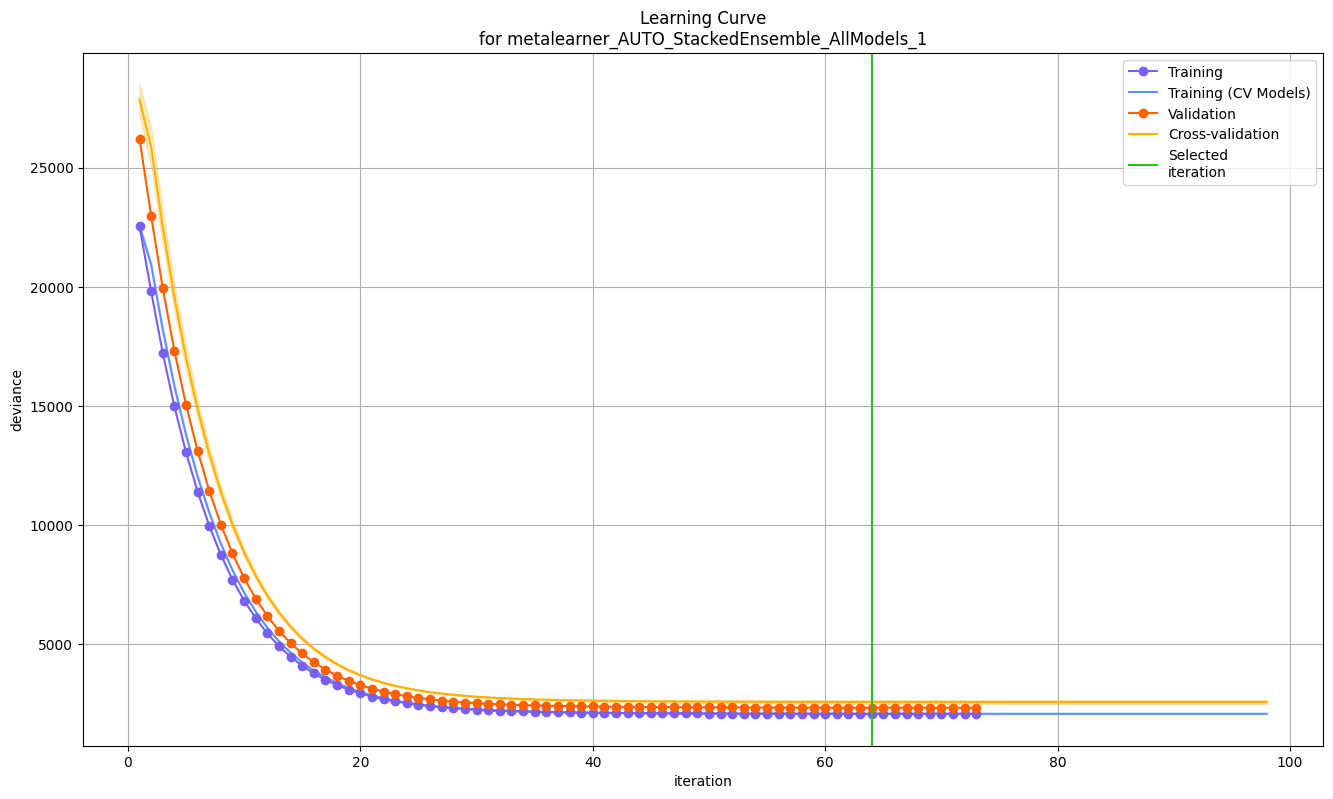

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

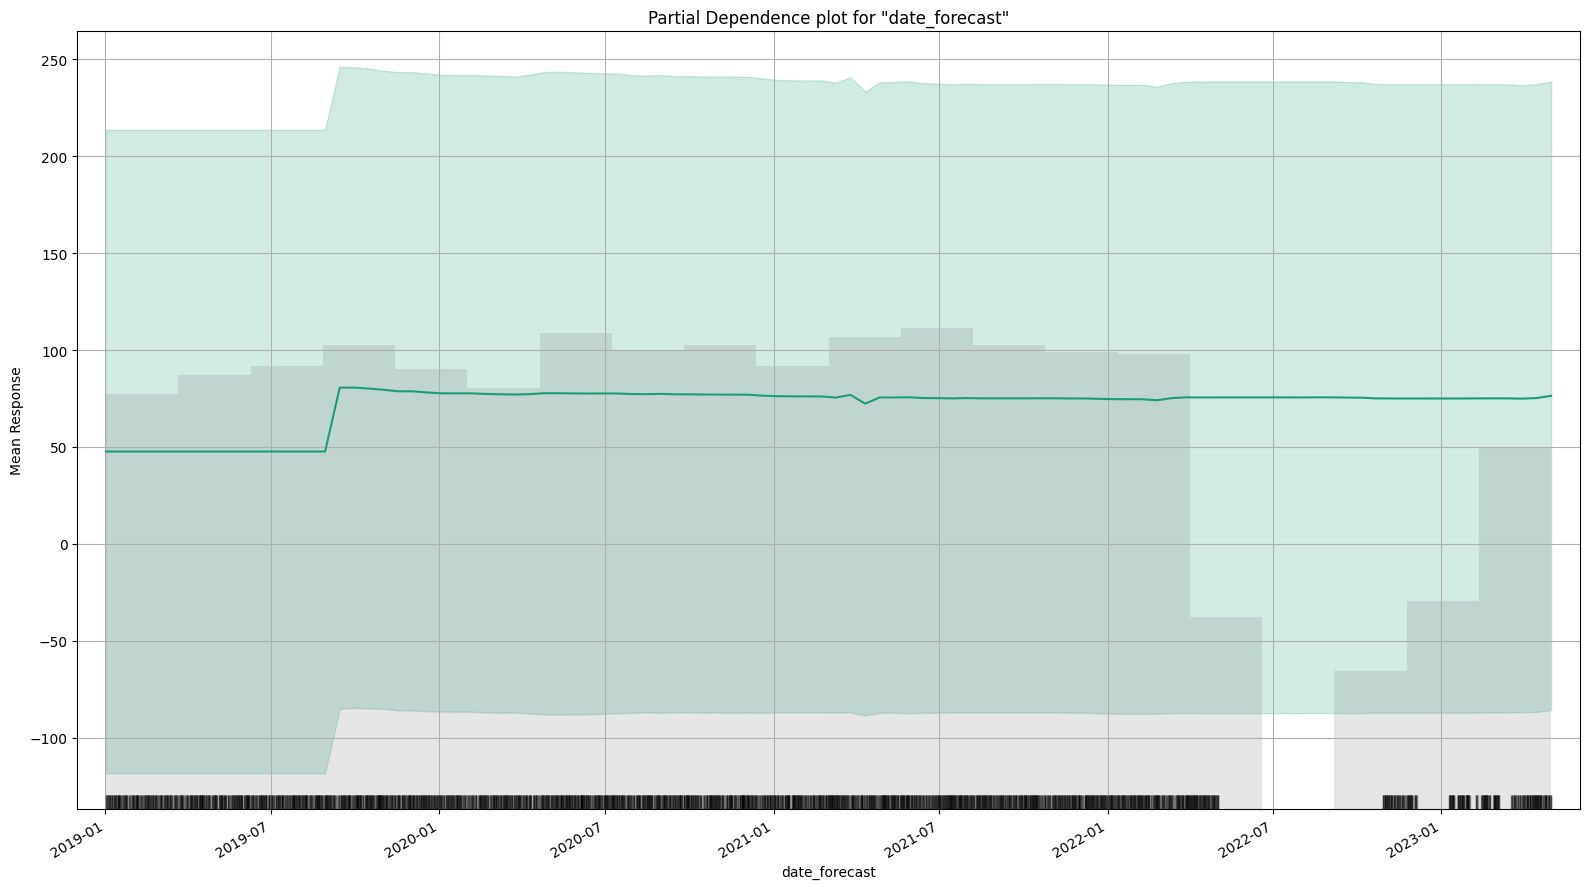

In [ ]:
# H2O with data preprocess and two predictors (V2)

all_predictions = pd.DataFrame()
# Init of H2O
h2o.init(max_mem_size = "16G") # If u have more RAM change the parameter

for letter in ['A', 'B', 'C']:
    # Load data
    print(f"dataset {letter}")
    # Load data from Parquet files and concatenate them into a single DataFrame 'X'
    X = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    
    # Preprocess the data
    
    # Merge DataFrame 'X' and 'y' based on the common column "date_forecast"
    X_y_bacon = X.merge(y, left_on = "date_forecast", right_on = "time")
    
    # Remove rows with missing values in the "pv_measurement" variable
    X_y_bacon = X_y_bacon.dropna(subset = "pv_measurement")
    
    # List of columns to be dropped
   
    columns_to_drop = ["snow_drift:idx", "elevation:m", 'snow_melt_10min:mm','fresh_snow_12h:cm',
                       'fresh_snow_3h:cm',  'fresh_snow_6h:cm', 'wind_speed_w_1000hPa:ms', 
                       'snow_water:kgm2', 'snow_density:kgm3', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 
                       'wind_speed_v_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_10m:ms',
                       'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'dew_or_rime:idx', 
                       'date_forecast', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J', 
                       'dew_point_2m:K','super_cooled_liquid_water:kgm2', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'prob_rime:p','date_forecast']   
    
    
    # Remove specified columns from training data
    X_y_bacon.drop(columns=columns_to_drop+['time'], inplace=True)
    
    # Load test data and remove specified columns
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    X_test = X_test.iloc[::4]
    X_test.drop(columns=columns_to_drop, inplace=True)
    x_test = h2o.H2OFrame(X_test)

    
    # Split data into training and validation frames (80:20)
    train,test = sklearn.model_selection.train_test_split(X_y_bacon, test_size = 0.20)

    train_frame = h2o.H2OFrame(train)
    test_frame = h2o.H2OFrame(test)
    
    x = train_frame.columns[:-1] 
    y = train_frame.columns[-1] 
    
    # Create an AutoML model
    aml = H2OAutoML(max_runtime_secs = 60,
                    sort_metric = "MAE",
                    stopping_metric = "MAE",
                    seed = 7213712285) #7213712285
    aml.train(x = x, 
              y = y,
              training_frame = train_frame,
              validation_frame = test_frame)
    
    print(aml.leaderboard)
    best_model = aml.get_best_model(criterion='MAE')
    second_best_model = h2o.get_model(h2o.as_list(aml.leaderboard)["model_id"].iloc[1])
    
    # Make predictions on test data and make CSV file
    prediction1 = best_model.predict(x_test)
    predictions1_df = h2o.as_list(prediction1)
    predictions1_df[predictions1_df < 0.] = 0.
    
    prediction2 = second_best_model.predict(x_test)
    predictions2_df = h2o.as_list(prediction2)
    predictions2_df[predictions2_df < 0.] = 0.

    prediction = (predictions1_df["predict"] + predictions2_df["predict"])/2
    
    all_predictions = pd.concat([all_predictions, prediction], ignore_index=True)
    all_predictions.to_csv('AutoML_H2O-V2.csv', index_label='id')
    print("CSV file updated")

# Explain the best model on the validation frame for model interpretation
best_model.explain(test_frame)

# Shut down H2O
h2o.shutdown()
print("Done")

# H2O without data preprocess - USED IN SHORT NOTE (V3)

In [ ]:
# H2O without data preprocess - USED IN SHORT NOTE (V3)

all_predictions = pd.DataFrame()
# Init of H2O
h2o.init(max_mem_size = "16G") # If u have more RAM change the parameter

for letter in ['A', 'B', 'C']:
    # Load data
    print(f"dataset {letter}")
    # Load data from Parquet files and concatenate them into a single DataFrame 'X'
    X = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    
    # Preprocess the data
    
    # Merge DataFrame 'X' and 'y' based on the common column "date_forecast"
    X_y_bacon = X.merge(y, left_on = "date_forecast", right_on = "time")
    
    # Load test data and remove specified columns
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    X_test = X_test.iloc[::4]
    #X_test.drop(columns=columns_to_drop, inplace=True)
    x_test = h2o.H2OFrame(X_test)

    
    # Split data into training and validation frames (80:20)
    train,test = sklearn.model_selection.train_test_split(X_y_bacon, test_size = 0.20)

    train_frame = h2o.H2OFrame(train)
    test_frame = h2o.H2OFrame(test)
    
    x = train_frame.columns[:-1] 
    y = train_frame.columns[-1] 
    
    # Create an AutoML model
    aml = H2OAutoML(max_runtime_secs = 60,
                    sort_metric = "MAE",
                    stopping_metric = "MAE",
                    seed = 7213712285) 
    aml.train(x = x, 
              y = y,
              training_frame = train_frame,
              validation_frame = test_frame)
    
    print(aml.leaderboard)
    best_model = aml.get_best_model(criterion='MAE')
    
    # Make predictions on test data and make CSV file
    prediction1 = best_model.predict(x_test)
    predictions1_df = h2o.as_list(prediction1)
    predictions1_df[predictions1_df < 0.] = 0.
    
    all_predictions = pd.concat([all_predictions, predictions1_df], ignore_index=True)
    all_predictions.to_csv('AutoML_H2O-V3.csv', index_label='id')
    print("CSV file updated")

# Explain the best model on the validation frame for model interpretation
best_model.explain(test_frame)

# Shut down H2O
h2o.shutdown()
print("Done")

## Another possible solutions

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
y_train = pd.read_parquet("../../dataset/A/train_targets.parquet")
X_train_observed = pd.read_parquet("../../dataset/A/X_train_observed.parquet")
X_train_estimated = pd.read_parquet("../../dataset/A/X_train_estimated.parquet")
X_test = pd.read_parquet("../../dataset/A/X_test_estimated.parquet")
print(f"Observed {X_train_observed.shape}")
print(f"Estimated {X_train_estimated.shape}")
print(f"y {y_train.shape}")
print(f"Test {X_train_observed.shape}")

When we took a deeper look on the data we found out, that snow_drift:idx are only 0. elevation:m is constant, so we can remove them, but we should add a way to distinguish the 3 buildings afterward (probably is_a, is_b and is_c columns) if we use all 3 to train 1 model.
 
Then we did correlation of the parameters and regression. We figured out we are not using wind and snow parameters a lot.
But the snow should be a good indicator of low energy production, we should try to connect its features into one: is_snow 

All the pressure features are really high correlated, so we can use only one of them. I chose the surface pressure

All clear_sky_energy_1h:J and clear_sky_rad:W are also really high correlated, lest drop the 1h value, the same for direct_rad and diffuse_rad

Humidity and dew_point are also highly correlated, and We don't think we need them both, let's drop the dew_point_2m:K 

And We are not sure if super_cooled_liquid_water:kgm2 ceiling_height_agl:m cloud_base_agl:m prob_rime:p can have some impact to energy production, but let's assume they do not 


dew_or_rime:idx is column with 1 for dew and -1 for rime, mby we should split this to two indexes

we should split datetime to year, day and hour

and we can add vector of ones, that can help for some regression techniques

So we made a function:

In [ ]:
def preprocess(X):
    
    X['snow_density:kgm3'] = X['snow_density:kgm3'].fillna(0)
    X = X.interpolate(axis=0)

    def is_snow(row):
        if row['fresh_snow_24h:cm'] > 0 or row['snow_depth:cm'] > 0:
            return 1
        else:
            return 0
    X['is_snow'] = X.apply(is_snow, axis=1)
    
    def is_dew(row):
        return 1 if row['dew_or_rime:idx'] > 0.1 else 0
    
    def is_rime(row):
        return 1 if row['dew_or_rime:idx'] < -0.1 else 0
    X['is_dew'] = X.apply(is_dew, axis=1)
    X['is_rime'] = X.apply(is_rime, axis=1)
    
    X['year'] = X['date_forecast'].apply(lambda x: x.year)
    X['day_of_year'] = X['date_forecast'].apply(lambda x: x.dayofyear)
    X['hour_of_day'] = X['date_forecast'].apply(lambda x: x.hour)
    
    columns_to_drop = ["snow_drift:idx", "elevation:m", 'snow_melt_10min:mm', 'fresh_snow_12h:cm', 'fresh_snow_3h:cm',  'fresh_snow_6h:cm', 'wind_speed_w_1000hPa:ms', 'snow_water:kgm2', 'snow_density:kgm3', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',  'wind_speed_v_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_10m:ms', 'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'dew_or_rime:idx', 'date_forecast', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J', 'dew_point_2m:K']
    columns_to_drop += ['super_cooled_liquid_water:kgm2', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'prob_rime:p']
    
    X.drop(columns=columns_to_drop, inplace=True)
    X.drop(["date_calc"], axis=1, inplace=True, errors='ignore')
    
    X['ones'] = 1
        
    return X

def normalise(X):
    return StandardScaler().fit_transform(X)

def make_y_15mins(y):
    y = y.loc[y.index.repeat(4)].reset_index(drop=True)
    y['time'] += y.groupby(y.index // 4).cumcount() * pd.Timedelta("15 min")
    
    y = y.dropna()
    return y


def match_x_and_y(X, y):
    y = y.dropna()
    X = X[X['date_forecast'].isin(y['time'])].reset_index(drop=True)
    y = y[y['time'].isin(X['date_forecast'])].reset_index(drop=True)
    return X, y

def drop_time(y):
    return y.drop('time', axis=1)

def compute_mne(pred, truth):
    pred[pred < 0] = 0
    mae_nn = np.mean(np.abs(np.array(truth) - pred))
    return mae_nn

def mean_15min_output(y):
    y[y < 0.] = 0
    meany = np.zeros(y.shape[0] // 4)
    
    for i in range(meany.shape[0]):
        meany[i] = np.mean(y[4*i: 4*(i+1)])
    
    return meany

def mean_15minX(X):
    ret = X.iloc[:,1:].groupby(np.arange(len(X))//4).mean()
    ret.insert(0, 'date_forecast',list(X.loc[::4, 'date_forecast']))
    return ret
    
def create_csv(y, name='model.csv'):
    y[y < 0.] = 0.
    output = pd.DataFrame({'prediction': y})
    output.to_csv(name, index_label='id')
    


Now we try it on linear regression:

In [ ]:
prediction = []

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)
    
    y_train = make_y_15mins(y_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    y_train = drop_time(y_train)
    X_train = preprocess(X_train)
    X_test = preprocess(X_test)
    
    ML = LinearRegression()
    model = ML.fit(X_train, y_train)   
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.vstack((prediction, model.predict(X_test)))

prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0. # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('dropped_columns_regression.csv', index_label='id')
print("done")
    

Also on Random Forest Regressor:

In [ ]:
prediction = []
from sklearn.ensemble import RandomForestRegressor

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)
    
    y_train = make_y_15mins(y_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = preprocess(X_test)
    
    
    ML = RandomForestRegressor(random_state = 42)
    model = ML.fit(X_train, y_train['pv_measurement'])   
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))
    

prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0. # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('dropped_columns_forest.csv', index_label='id')
print("done")

We could also try to do one big hour features row instead of meaning four smaller

In [ ]:
y_train = pd.read_parquet("../../dataset/A/train_targets.parquet")
X_train_observed = pd.read_parquet("../../dataset/A/X_train_observed.parquet")

def join_X_hour(X):
    extra_columns = ['hour_of_day', 'day_of_year', 'year']

    X1 = X_train_observed[::4].reset_index()
    X2 = X_train_observed[1::4].reset_index().add_suffix("_+15").drop(columns=extra_columns)
    X3 = X_train_observed[2::4].reset_index().add_suffix("_+30").drop(columns=extra_columns)
    X4 = X_train_observed[3::4].reset_index().add_suffix("_+45").drop(columns=extra_columns)

    return  pd.concat([X1,X2,X3,X4], axis=1)



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


y_train = pd.read_parquet("../../dataset/A/train_targets.parquet")
X_train_observed = pd.read_parquet("../../dataset/A/X_train_observed.parquet")
y_test = pd.read_parquet("../../dataset/A/train_targets.parquet")
x_test = pd.read_parquet("../../dataset/A/X_train_estimated.parquet")


y_train = make_y_15mins(y_train)
X_train_observed, y_train = match_x_and_y(X_train_observed, y_train)
X_train_observed = preprocess(X_train_observed)
cols = X_train_observed.columns

y_test = make_y_15mins(y_test)
x_test, y_test = match_x_and_y(x_test, y_test)
x_test = preprocess(x_test)



# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [8,  100, 500],
    'max_features': [2,  3, 20],
    'min_samples_leaf': [2 , 4, 20],
    'min_samples_split': [2, 8 , 20],
    'n_estimators': [10, 100, 1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                         cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
grid_search.fit(X_train_observed, y_train['pv_measurement']);




In [ ]:
best_params = grid_search.best_params_
"""best_params = {'n_estimators': 1000,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 3,
 'max_depth': 100,
 'bootstrap': True}"""
best_params

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')

In [ ]:
prediction = []
from sklearn.ensemble import RandomForestRegressor

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)
    
    y_train = make_y_15mins(y_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = preprocess(X_test)
    
    
    ML = RandomForestRegressor(random_state = 42, **best_params )
    model = ML.fit(X_train, y_train['pv_measurement'])   
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))
    

prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0. # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('random_search_params_forest.csv', index_label='id')
print("done")

Do mean of every 4 rows instead of meaning results

In [ ]:
X = pd.read_parquet(f"../../dataset/A/X_train_observed.parquet")
mean_15minX(X)

In [ ]:
prediction = []
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)

    X_train = mean_15minX(X_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = X_test.drop('date_calc', axis=1)
    X_test = mean_15minX(X_test)
    X_test = preprocess(X_test)

    ML = RandomForestRegressor(random_state=42, **best_params)
    model = ML.fit(X_train, y_train['pv_measurement'])
    print(mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement'])))
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))

#prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0.  # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('meaned_X_dropped_column_random_forrest.csv', index_label='id')
print("done")


Let's try esemble learning

In [ ]:
prediction = []
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.ensemble import HistGradientBoostingRegressor



linreg_pipeline=make_pipeline(
    StandardScaler(), LinearRegression()
)
lasso_pipeline=make_pipeline(
    StandardScaler(), LassoCV()
)

estimators = [('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', lasso_pipeline),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=42)),
              ('Linear Regression', LinearRegression()),
              ('Adaboost', AdaBoostRegressor(random_state=42)),
              ]

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)

    X_train = mean_15minX(X_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = X_test.drop('date_calc', axis=1)
    X_test = mean_15minX(X_test)
    X_test = preprocess(X_test)
    
    

    stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

    
    model = stacking_regressor.fit(X_train, y_train['pv_measurement'])
    print(mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement'])))
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))

#prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0.  # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('stacking_droped_meanedX.csv', index_label='id')
print("done")

In [ ]:
#The same with meaning y instead
prediction = []
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.ensemble import HistGradientBoostingRegressor



linreg_pipeline=make_pipeline(
    StandardScaler(), LinearRegression()
)
lasso_pipeline=make_pipeline(
    StandardScaler(), LassoCV()
)

estimators = [('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', lasso_pipeline),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=42)),
              ('Linear Regression', LinearRegression()),
              ('Adaboost', AdaBoostRegressor(random_state=42)),
              ]

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)

    y_train = make_y_15mins(y_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = X_test.drop('date_calc', axis=1)
    X_test = preprocess(X_test)
    
    

    stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

    
    model = stacking_regressor.fit(X_train, y_train['pv_measurement'])
    print(mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement'])))
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))

prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0.  # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('stacking_droped_meanedY.csv', index_label='id')
print("done")